Moon Density: 3341.8 kg/m³


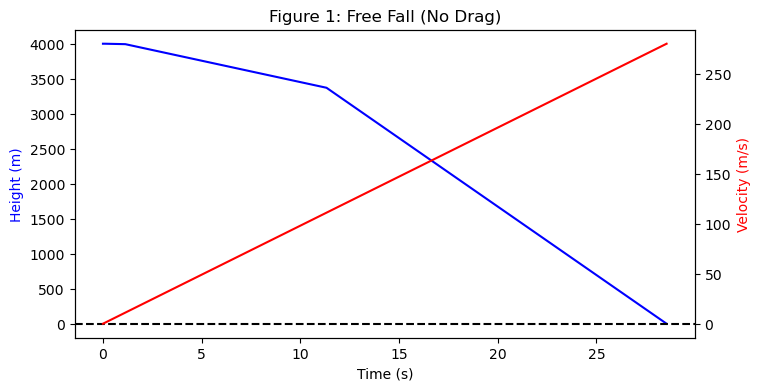

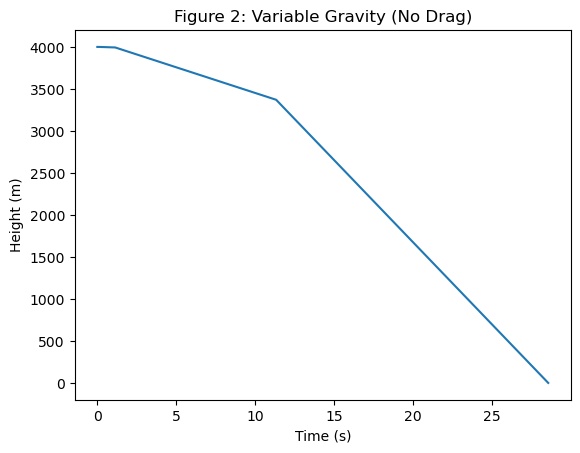

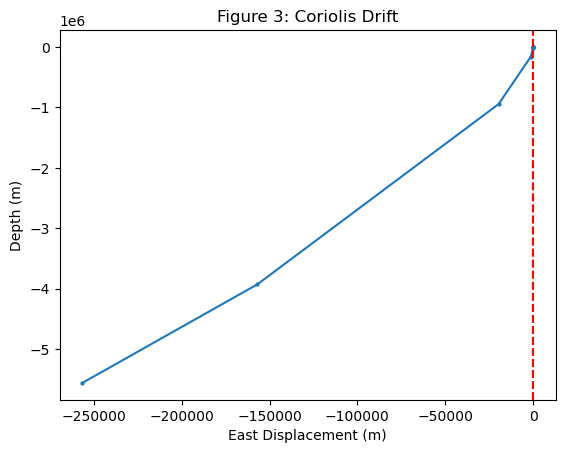

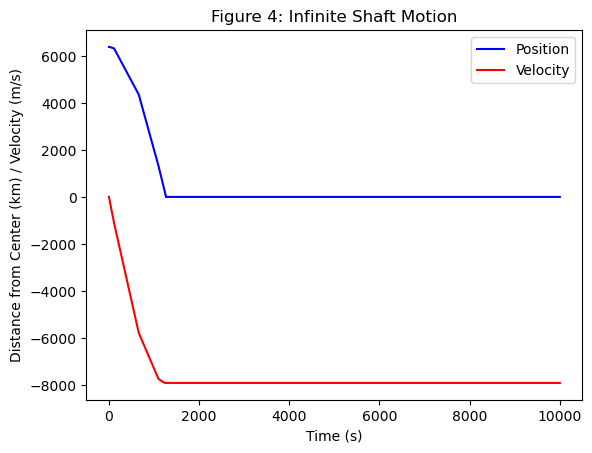

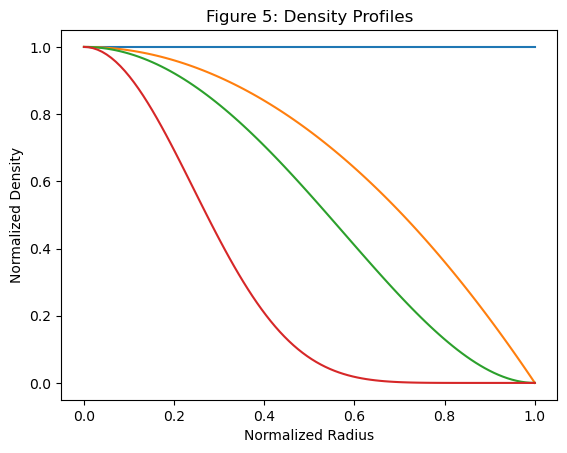

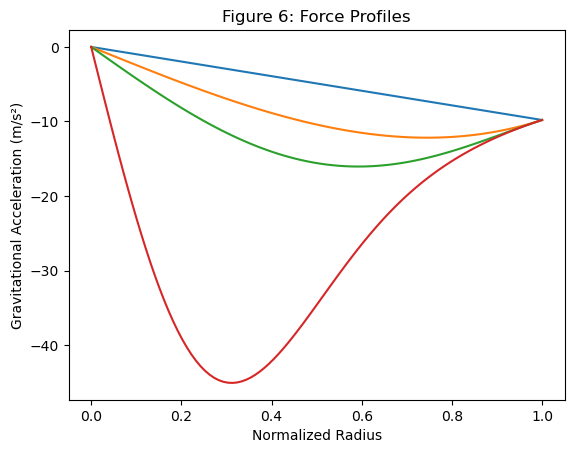

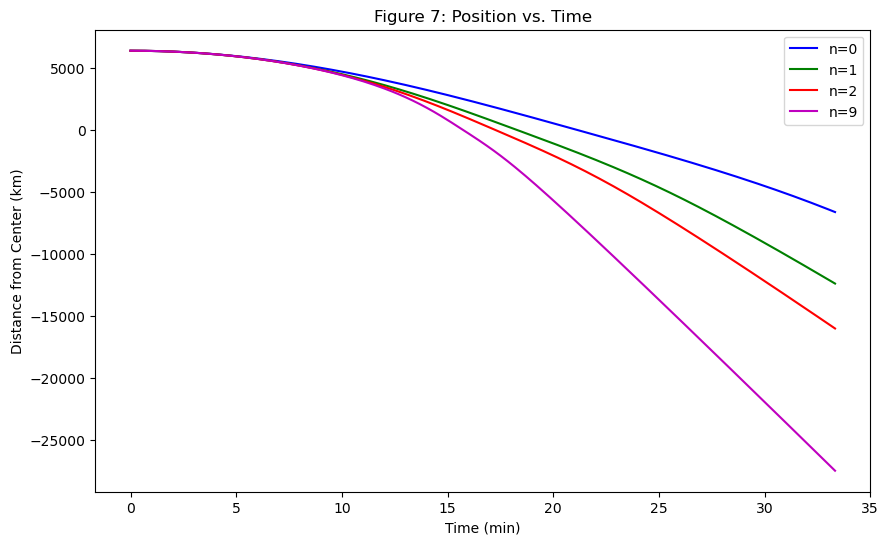

In [2]:
import numpy as np
from scipy.integrate import solve_ivp, quad
import matplotlib.pyplot as plt

G = 6.6743e-11
g0 = 9.81
M_earth = 5.972e24
R_earth = 6378100
M_moon = 7.35e22
R_moon = 1738100
Omega = 7.272e-5
h_shaft = 4000
alpha = 0.003924
gamma = 2

def ode_part1(t, state):
    return [state[1], -g0]

def event_hit_bottom(t, state):
    return state[0]
event_hit_bottom.terminal = True
event_hit_bottom.direction = -1

sol_part1 = solve_ivp(ode_part1, [0, 100], [h_shaft, 0], events=event_hit_bottom)

fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(sol_part1.t, sol_part1.y[0], 'b-')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Height (m)', color='b')
ax1.axhline(0, ls='--', color='k')
ax2 = ax1.twinx()
ax2.plot(sol_part1.t, -sol_part1.y[1], 'r-')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax1.set_title('Figure 1: Free Fall (No Drag)')

def ode_part2(t, state):
    y, v = state
    r = R_earth - (h_shaft - y)
    g = g0 * (r / R_earth)
    drag = alpha * abs(v)**gamma
    return [v, -g + drag if v < 0 else -g - drag]

alpha_temp = alpha
alpha = 0
sol_part2 = solve_ivp(ode_part2, [0, 100], [h_shaft, 0], events=event_hit_bottom)
alpha = alpha_temp

plt.figure()
plt.plot(sol_part2.t, sol_part2.y[0])
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.title('Figure 2: Variable Gravity (No Drag)')

def ode_part3(t, state):
    x, y, vx, vy = state
    r = R_earth - y
    g = g0 * (r / R_earth)
    drag = alpha * abs(vy)**gamma
    return [vx, vy, 2 * Omega * vy, -2 * Omega * vx - g + drag]

def event_hit_bottom_part3(t, state):
    return state[1] - h_shaft
event_hit_bottom_part3.terminal = True

alpha_temp = alpha
alpha = 0
sol_part3 = solve_ivp(ode_part3, [0, 1000], [0, 0, 0, 0], events=event_hit_bottom_part3)
alpha = alpha_temp

plt.figure()
plt.plot(sol_part3.y[0], sol_part3.y[1], '.-', markersize=4)
plt.axvline(x=2.5, color='r', linestyle='--')
plt.axvline(x=-2.5, color='r', linestyle='--')
plt.xlabel('East Displacement (m)')
plt.ylabel('Depth (m)')
plt.title('Figure 3: Coriolis Drift')

def ode_part4(t, state):
    y, v = state
    if y <= 0: return [0, 0]
    return [v, -g0 * (y / R_earth)]

sol_part4 = solve_ivp(ode_part4, [0, 1e4], [R_earth, 0], events=lambda t, s: s[0])

plt.figure()
plt.plot(sol_part4.t, sol_part4.y[0]/1e3, 'b-', label='Position')
plt.plot(sol_part4.t, sol_part4.y[1], 'r-', label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Distance from Center (km) / Velocity (m/s)')
plt.title('Figure 4: Infinite Shaft Motion')
plt.legend()

n_values = [0, 1, 2, 9]
colors = ['b', 'g', 'r', 'm']

def compute_rho_n(n, Rn=R_earth):
    integral, _ = quad(lambda r: (1 - (r**2)/(Rn**2))**n * r**2, 0, Rn)
    return M_earth / (4 * np.pi * integral)

def g_nonuniform(r, n):
    if r <= 1e-10: return 0.0
    elif r > R_earth: return -G * M_earth / r**2
    else:
        rho_n = compute_rho_n(n)
        integral, _ = quad(lambda x: (1 - (x**2)/(R_earth**2))**n * x**2, 0, r)
        return -G * 4 * np.pi * rho_n * integral / r**2

plt.figure()
r = np.linspace(0, R_earth, 100)
for n in n_values:
    plt.plot(r/R_earth, (1 - (r**2)/(R_earth**2))**n, label=f'n={n}')
plt.xlabel('Normalized Radius')
plt.ylabel('Normalized Density')
plt.title('Figure 5: Density Profiles')

plt.figure()
for n in n_values:
    g = [g_nonuniform(r_i, n) for r_i in r]
    plt.plot(r/R_earth, g, label=f'n={n}')
plt.xlabel('Normalized Radius')
plt.ylabel('Gravitational Acceleration (m/s²)')
plt.title('Figure 6: Force Profiles')

plt.figure(figsize=(10, 6))
for n, color in zip(n_values, colors):
    sol = solve_ivp(lambda t, y: [y[1], g_nonuniform(abs(y[0]), n)], [0, 2e3], [R_earth, 0], events=lambda t, s: s[0], max_step=10)
    plt.plot(sol.t / 60, sol.y[0]/1e3, color=color, label=f'n={n}')
plt.xlabel('Time (min)')
plt.ylabel('Distance from Center (km)')
plt.title('Figure 7: Position vs. Time')
plt.legend()

rho_moon = M_moon / ((4/3)*np.pi*R_moon**3)
print(f"Moon Density: {rho_moon:.1f} kg/m³")

plt.show()